## ASSOCIATION RULE/PATTERN MINING FOR RECOMMENDER SYSTEM

## Imports

In [41]:
# Data Processing
import pandas as pd
import numpy as np
import scipy.stats
import random
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from collections import OrderedDict

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Supress Warnings
from warnings import filterwarnings
filterwarnings("ignore")

# Time
import time

## Useful User defined functions

In [2]:
# This function reads the data from csv file and returns the dataset
def read_data(filename):
    """
    Reads the data in the csv file using pandas
    
    Parameters: filename
    
    Returns the dataframe
    """
    return pd.read_csv(filename)

In [30]:
def sort_dataset(dataset):
    """
    Sort the data set according to date and member_number
    
    parameters - dataset
    
    Returns a sorted data set
    """
    
    # Sort the data set according to year, month, day and Member_number
    dataset.sort_values(['Member_number'], inplace = True)
    
    return dataset

In [4]:
# Convert dtype of the variables to object
def convert_type(dataset, variables):
    """
    Converts the type of the columns in the given dataframe
    
    Parameters: dataframe, variables
    
    Returns the dataframe
    """
    for var in variables:
        dataset[var] = dataset[var].astype('object')
    return dataset

In [67]:
# Drop not so useful columns from the dataset
def drop_columns(dataset):
    """
    Drops not so useful columns from the dataset
    
    Parameters: dataframe
    
    Returns the dataframe
    """
    
    # Drop the below columns
    dataset.drop(["Date", "year", "month", "day", "day_of_week"], axis = 1, inplace = True)
        
    return dataset

In [68]:
# Generate a word cloud chart to depict frequencies of items in the data set
def generate_word_cloud(dataset):
    """
    Generates a cloud of words where the higher the text size indicates the greater the count
    
    parameters - dataframe
    
    Prints the plot
    """
    
    # Join all the items in a single string
    labels = ' '.join(dataset["itemDescription"].astype(str).tolist())
    
    # Implenting the cloud
    word_cloud = WordCloud(width = 1000, 
                           height = 1000, 
                           background_color = 'black', 
                           colormap = 'RdBu',
                           stopwords=[], 
                           min_font_size = 6).generate(labels)
    
    # Adjust Size of the plot
    plt.figure(figsize=(10, 10))
    
    # Display the chart
    plt.imshow(word_cloud)
    
    # Remove the axis
    plt.axis("off")
    
    # Adjust the words from overlapping
    plt.tight_layout(pad=0)
    
    # Show the plot
    plt.show()

## Read the Data set

In [89]:
# Read the training data
groceries_train = read_data("Groceries data train.csv")

# Read the test data
groceries_test = read_data("Groceries data test.csv")

# Print the first two rows of the data set
groceries_train.head(2)

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5


## Analyse and Visualise the Training Data

In [76]:
# Shape of the data set
groceries_train.shape

(27000, 7)

In [77]:
# General Information about Training Data
groceries_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    27000 non-null  int64 
 1   Date             27000 non-null  object
 2   itemDescription  27000 non-null  object
 3   year             27000 non-null  int64 
 4   month            27000 non-null  int64 
 5   day              27000 non-null  int64 
 6   day_of_week      27000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.4+ MB


In [90]:
# Convert Member_number and year from type integer to type object
groceries_train = convert_type(groceries_train, ["Member_number", "year", "month", "day", "day_of_week"])

# Convert Member_number and year from type integer to type object
groceries_test = convert_type(groceries_test, ["Member_number", "year", "month", "day", "day_of_week"])

In [79]:
# Summary Statistics for training data
groceries_train.describe()

,Member_number,Date,itemDescription,year,month,day,day_of_week
count,27000,27000,27000,27000,27000,27000,27000
unique,3872,728,167,2,12,31,7
top,3050,21/07/2015,whole milk,2015,8,28,3
freq,26,70,1709,14284,2418,994,3999


**Observation:**
* Data is collected across two years
* Whole Milk is the product which is highest sold (1709 sales)
* Member_number - 3050 is the most active customer (Bought 26 items)

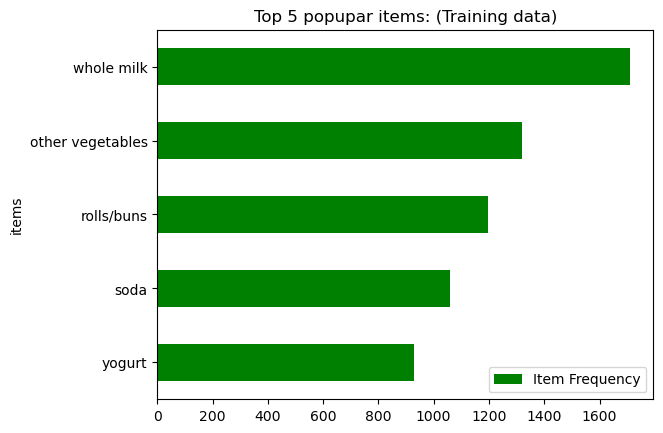

In [87]:
# Create a data frame
df_barh = pd.DataFrame(groceries_train.itemDescription.value_counts()[:5][::-1])\
                  .reset_index()\
                  .rename(columns = {'itemDescription':'Item Frequency', 'index':'items'})

# Plot a bar chart
df_barh.plot.barh(x='items', y='Item Frequency',
                  title='Top 5 popupar items: (Training data)', color='green')

plt.show()

#### Observations:

* Horizontal bar graph showing the popular items in the training dataset.


* These items will be the most recommended items.
<br>
<br>

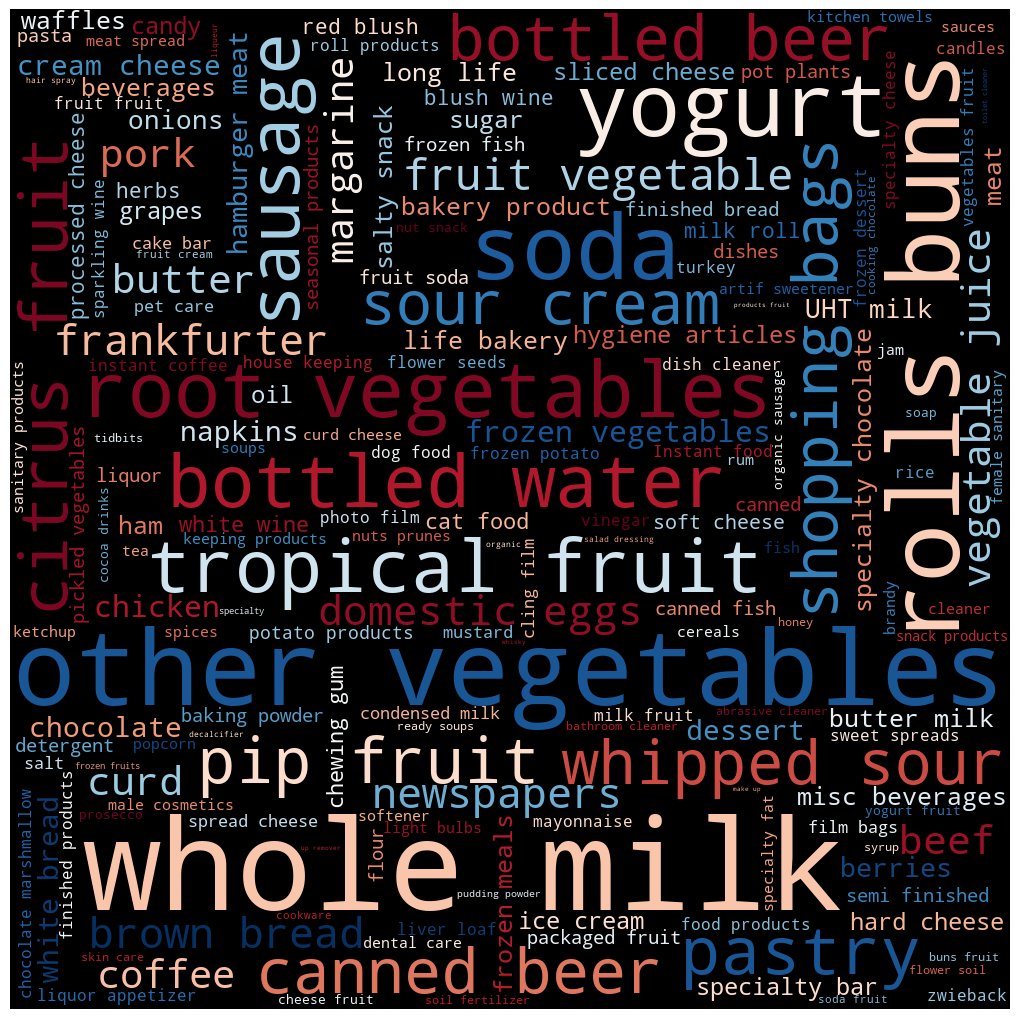

In [86]:
# Using word cloud display frequency of items in the training dataset
generate_word_cloud(groceries_train)

**Observation:**

From above we can notice the top five most frequently selling items based on label size, They are:
* Whole Milk
* other vegetables
* rolls/buns
* soda
* yogurt

Hence while generating recommendations we might expect these top selling products to be recommended mostly

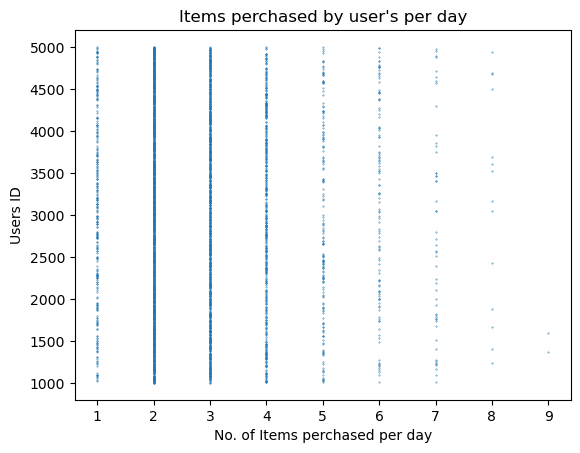

In [84]:
df_m = pd.DataFrame(pd.DataFrame(groceries_train.groupby(['Member_number'])['Date']\
                                             .value_counts())\
                                             .reset_index(level='Date', drop=True)\
                                             .groupby(['Member_number'])['Date'].max())\
                .reset_index()\
                .rename(columns = {'Date':'No. of Items perchased per day',\
                                   'Member_number': 'Users ID'})

df_m.plot.scatter(x = 'No. of Items perchased per day', y = 'Users ID', s = 0.1,\
                  title="Items perchased by user's per day")

plt.show()

#### Observations:

* here maximun mean value of Items perchased by user's per day is 3 from the scatter plot.

* So we have to recommended top 3 items for our grocery transactions.
<br>
<br>

In [91]:
# Sort the training data according to year, month, day and Member_number
groceries_train = sort_dataset(groceries_train)

# Sort the test data according to year, month, day and Member_number
groceries_test = sort_dataset(groceries_test)

In [92]:
# Drop not so useful columns from the dataset
groceries_train = drop_columns(groceries_train)

# Drop not so useful columns from the dataset
groceries_test = drop_columns(groceries_test)

In [71]:
print("In Training data:")
pd.DataFrame({'unique count': [len(groceries_train.Member_number.unique()),
                               len(groceries_train.itemDescription.unique())]},
              index=['Member_number', 'itemDescription'])

In Training data:


,unique count
Member_number,3872
itemDescription,167


#### Observations:

* In this grocery dataset, the number of Member_numbers is much greater than the number of distinct itemDescriptions. This means that each user in the dataset has likely selected a different set of items, and as a result, has a unique pattern of item selection behavior.


* By analyzing this pattern of item selection behavior, we can find users who have similar item preferences and use this information to implement a grocery recommendation system. This can be done using collaborative filtering, which is a technique that uses the behavior of similar users to make recommendations.


* Another technique that can be used to find patterns in the grocery transaction dataset is associative mining. This technique can be used to identify which items are frequently purchased together by different users.


* For our dataset we can combine collaborative filtering and associative mining, we can create a powerful grocery recommendation system that provides personalized recommendations to users based on their item selection behavior. 
<br>
<br>

In [93]:
df_c = pd.merge( pd.DataFrame(groceries_train.Member_number.value_counts()),
                 pd.DataFrame(groceries_train.groupby(['Member_number'])['itemDescription'].nunique()),
                 left_index = True, right_index = True)\
                 .rename(columns = {'itemDescription':'unique count', 'Member_number':'total count'})

pd.DataFrame({"mean unique item count": df_c['unique count'].mean(),
              "mean total item count": df_c['total count'].mean(),
              "mean Percentage of new items": (df_c['unique count'].mean()/df_c['total count'].mean())*100,
              "mean Percentage of items repeated": (1-(df_c['unique count'].mean()/df_c['total count'].mean()))*100},
              index=["For each user's entire transcation"])

,mean unique item count,mean total item count,mean Percentage of new items,mean Percentage of items repeated
For each user's entire transcation,6.459194,6.97314,92.62963,7.37037


#### Observations:

* It appears that users are buying new items in their each grocery transaction with a mean percentage of 92, which suggests that they are not buying the same items repeatedly in each transaction. Therefore, comparing user grocery transactions based on date may not be useful for identifying trends or patterns in their purchasing behavior. So we can drop date & time based columns in datasets.


* By creating an entire transaction history for each user, we can create an item or user matrix that captures which users purchase certain items. From this matrix, we can identify similar users or items and gain a deeper understanding of user purchasing behavior. This information could then be used to make targeted product recommendations.


* We can predict repeated items in user grocery transactions, even if the chance of repetition is only 7%. It is important to balance recommendations for repeated items with recommendations for new or complementary items, to ensure that users are exposed to a variety of products and have a positive shopping experience.

<br>
<br>

In [94]:
groceries_train['value'] = 1
#creating the user-item interaction matrix
grocery_pivot = groceries_train.pivot_table(index='Member_number',\
                                            columns='itemDescription',\
                                            values='value')
grocery_pivot = grocery_pivot.fillna(0)

# Display first two rows of the groupby data frame
grocery_pivot.head(2)

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


#### Observations:

* The approach involves creating a binary user-item matrix from entire transaction histories. Items are recommended to users based on purchasing patterns, and the binary format is used for the apriori method. The matrix can be used to identify similar users and to make targeted recommendations.


<br>
<br>

In [98]:
groceries_test = pd.DataFrame(groceries_test.\
                              groupby(['Member_number'])\
                              ['itemDescription'].unique())
groceries_test.head(2)

,itemDescription
Member_number,
1000,"[whole milk, salty snack, semi-finished bread,..."
1001,[frankfurter]


#### Observations:

* This approach involves using entire training transaction histories for each user to create an item or user matrix. From the matrix, items are recommended to users based on their purchasing patterns. 


* Mean reciprocal rank (MRR) is used to evaluate the accuracy of recommendations, which measures how quickly the correct item is recommended to the user.


* Test data is modified to include expected transaction histories for each user. This approach allows for more accurate evaluation of the recommendation system and ensures recommended items are relevant to each user's individual purchasing patterns.

<br>
<br>

## Generate Recommendations from Training Data using Collaborative Filtering

In [99]:
#Use cosine similarity from the package sklearn.metrics.pairwise to get matrix representing similarity values 
# between users

# Use Cosine similarity using the pivot table generated before with filling null values with 0
user_similarity_cosine = cosine_similarity(grocery_pivot.fillna(0))

# Similarity values for the first user with other users
user_similarity_cosine[0]

array([1.        , 0.25197632, 0.        , ..., 0.        , 0.        ,
       0.18898224])

In [12]:
# Shape of the similarity matrix
user_similarity_cosine.shape

(3872, 3872)

A row in the matrix indicates a transaction and the values represent the similarity of this transactrion with all the other transactions

<br/>

In [13]:
# Creating a list of all the Users in the training data
all_members = groceries_train['Member_number'].unique().tolist()
all_members.sort()

In [14]:
# Create a data frame to store Users and recommendations
cols = ["Member_number", "Items_Bought_Train", "Recommendations"]
recommendation_df = pd.DataFrame(columns = cols)

In [100]:
# Generate Recommendations
def generate_recommendations():
    """
    This function generates recommendations for all the Users in the training dataset
    
    Output: Prints the recommendations for every User in the training dataset
    """
    
    # Declare the data frame recommendation_df as global
    global recommendation_df
    
    # We will check the recommendations for all the users
    for i,user in enumerate(all_members):
        
        # Create a list of similarity scores for a user with other users
        similarity_score = list(enumerate(user_similarity_cosine[all_members.index(user)]))
        # Sort the similarities with similarities in descending order
        sorted_items = sorted(similarity_score, key = lambda x:x[1], reverse = True)
        
        # Create a list to store users based on similarity scores obtained before
        similar_users = []
        for similar_user in sorted_items[1:]:
            # fetch the index(first element of the tuple)
            user_index = similar_user[0]
            # Get the similarity value
            user_similarity = similar_user[1]
                
            # I am assuming a threshold of 0.5 to filter our best similar users
            # Very high similarities like above 0.9 is not viable because no two users buy the same products
            # throught the duration. 
            # Hence I am reducing the threshold to also obtain other products bought along with these products
            if (user_similarity > 0.50):
                # Obtain the transaction using the index
                similar_user = all_members[user_index]
                # Append to the list similar_transactions
                similar_users.append(similar_user)

        # Obtain the products purchased by the current user
        bought_products = groceries_train.loc[groceries_train.Member_number == user, 
                                                  "itemDescription"].copy()
        # Convert the pandas series object to a list
        bought_products = list(bought_products)
            
        # Obtain the products purchased by the users similar with our current user
        similar_items_bought = []
        # Checking for each user in similar users
        for u in similar_users:
            # Obtain the products
            items = groceries_train.loc[groceries_train.Member_number == u, "itemDescription"]
            # Append to the list
            similar_items_bought.append(list(items))
                
        # Obtain the items which are not purchased by the current user which were purchased in 
        # similar transactions with our current transaction
        untried_items = []
        for t in similar_items_bought:
            for item in t:
                # Obtain the untried products
                if item not in bought_products:
                    # Append to the list
                    untried_items.append(item)
                        
        # Import operator to get values in dictionary
        import operator
        # Create a dictionary
        frequency = {}
        # Now we are checking which item in untried products is bought and 
        # how many times they are bought by similar users
        for item in untried_items:
            # Add the item in dictionary if not present
            if item in frequency:
                frequency[item] += 1
            # Increment the count if present
            else:
                frequency[item] = 1
                    
        # Sort the dictionary items with items in descending order with items bought more frequently
        frequency = dict(sorted(frequency.items(), key=operator.itemgetter(1),reverse=True))
        
        # Obtain recommendations from the above dictionary
        recommended_items = []
        # Iterate through the dictionary and grab the top three most frequent items bought 
        # by similar users
        for j,key in enumerate(frequency.keys()):
            if j <= 2:
                recommended_items.append(key)
            
        # Print the recommendations
        # print("For Member -", user)
        # print("The top three recommended products are", recommended_items, "\n")
            
        # Add transaction, Items Bought by the user, respective recommendations into recommendation_df
        new_row = { 'Member_number': user, 'Items_Bought_Train': bought_products, 
                   'Recommendations': recommended_items}
        recommendation_df = recommendation_df.append(pd.DataFrame([new_row],
                                                                      columns = recommendation_df.columns))
        
#start_time = time.time() 

# Generate Recommendations
generate_recommendations()

# end_time = time.time()
# m2_time = end_time - start_time
# print(f"Time taken: {m2_time:.4f} seconds")

**Observation:**

* We generated top three recommendations for each and every user in the training data considering a similarity threshold of 0.5
* We also observe that there are a few users who does not have any recommendations because, the transaction is less similar with other transactions implying that the all the similarities for the transaction are well below 0.5

**Testing scenario:**
We can now check the testing data and compare the other products bought by the same user with our recommended products. In simple terms, we can say how many of the products in test set matches with our recommendations

## Apriori [4]

In [306]:
# function to return patterns and association rules
def apriori_p(data, s_min):
    # generate frequent itemsets
    frequent_itemsets = apriori(data, min_support=s_min, use_colnames=True)
    # Use association rules to generate recommendations
    rule = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
    return rule.sort_values(by='confidence', ascending=False)

## Hybrid model [1]

In [2]:
# Define a function to get top N new and repeated recommendations for a user
def get_recommendations_p(df, user_id, rules, N=3):
    # Get the items that the user has already rated
    user_items = df.loc[df['Member_number'] == user_id, 'itemDescription'].tolist()[0]

    # Filter the association rules to find those that involve at least one of the user's items
    relevant_rules = rules[rules['antecedents'].apply(lambda x: set(user_items).issuperset(x))]

    # Get the items that are recommended by the relevant rules
    recommended = relevant_rules['consequents'].apply(lambda x: list(x)[0]).tolist()

    # Total recommended items that include new and old (repeat)
    total_items = list(OrderedDict.fromkeys([item for item in recommended]))
    
    recommended_items = []
    count1 = 0
    for i in total_items:
        if i not in user_items and count1!=N:
            # getting top N recommended items in order of their rank
            recommended_items.append(i)
            count1 = count1 + 1
        if count1==N:
            break
        
    return recommended_items

def get_recommendations_c(df, user_id, ref, N=3):
    # list of all the Users in the training data
    all_members = ref['Member_number'].unique().tolist()
    all_members.sort()
    
    # calculate similarity between users using cosine similarity
    user_sim_matrix = cosine_similarity(df)

    # get similarity scores between the given user and all other users
    user_sim_scores = user_sim_matrix[all_members.index(user_id)]

    # sort the similarity scores in descending order and get the indices of the top similar users
    similar_users_idx = np.argsort(user_sim_scores)[::-1]
    
    # creating a dataframe sorted based on Similarity_score with Member_number and items as other columns
    df2 = pd.DataFrame({'Member_number': [all_members[i] for i in similar_users_idx],
                      'Similarity_score': np.sort(user_sim_scores)[::-1]})
    df_simi_user = df2[df2.Similarity_score.map(lambda x: x>0.2)]
    df_simi_user_data = pd.merge(df_simi_user, ref, on='Member_number')

    # return the dataframe which is a cluster dataset where this user belongs
    return df_simi_user_data

In [570]:
# finding recomendation for a random user using hybrid method
user_id2 = random.choice(list(groceries_train_data2.Member_number))
df_simi_user_data = get_recommendations_c(groceries_train_data, user_id2,
                                                           groceries_train_cleaned,N=3)
#creating the user-item interaction matrix
df_simi_user_data_as = df_simi_user_data.pivot_table(index='Member_number',\
                                                           columns='itemDescription',\
                                                           values='value')
df_simi_user_data_as = df_simi_user_data_as.fillna(0)
rules_2 = apriori_p(df_simi_user_data_as, 0.002)
df_simi_user_data_rec = get_recommendations_c(groceries_train_data, user_id2,
                                                           groceries_train_data2,N=3)

rec_items2  = get_recommendations_p(df_simi_user_data_rec,user_id2, rules_2, N=3)

print("For user", user_id2, ":")
print("\nTop 3 new recommendations are:")
history = groceries_train_data2.loc[groceries_train_data2['Member_number'] == user_id2, 'itemDescription']\
                               .values[0]
df_out = pd.DataFrame([[user_id2, history, rec_items2[0], rec_items2[1], rec_items2[2]],\
                    ], columns=["USER ID", "Transaction History (Train Dataset)", "1st Recommendation",\
                                '2st Recommendation', "3rd Recommendation"])
df_out

For user 4509 :

Top 3 new recommendations are:


,USER ID,Transaction History (Train Dataset),1st Recommendation,2st Recommendation,3rd Recommendation
0,4509,"(butter milk, sliced cheese, pork, soda, fruit...",other vegetables,yogurt,bottled beer


## Association rule then Collaborative filtering [2] [3]

In [560]:
# finding recomendation for a random user
rules_1 = apriori_p(groceries_train_data, 0.002)
groceries_train_data2 = pd.DataFrame(groceries_train_cleaned.\
                                   groupby(['Member_number'])\
                                   ['itemDescription'].unique().map(tuple))\
                                   .reset_index()
user_id = random.choice(list(groceries_train_data2.Member_number))
rec_items  = get_recommendations_p(groceries_train_data2,user_id, rules_1, N=3)

print("For user", user_id, ":")
print("\nTop 3 new recommendations are:")
history = groceries_train_data2.loc[groceries_train_data2['Member_number'] == user_id, 'itemDescription']\
                               .values[0]
df_out = pd.DataFrame([[user_id, history, rec_items[0], rec_items[1], rec_items[2]],\
                    ], columns=["USER ID", "Transaction History (Train Dataset)", "1st Recommendation",\
                                '2st Recommendation', "3rd Recommendation"])
df_out

For user 3887 :

Top 3 new recommendations are:


,USER ID,Transaction History (Train Dataset),1st Recommendation,2st Recommendation,3rd Recommendation
0,3887,"(pork, bottled water, shopping bags)",whole milk,other vegetables,soda


## Compare Training Recommendations with Test data [5] [6]

In [1]:
# retrive a random user which is present in test and train set
def id_find():
    while True:
        u_id = random.choice(list(groceries_train_data2.Member_number))
        if u_id in groceries_test_data.index:
            return u_id

In [22]:
# Convert the number of products bought by the user into an array
groceries_test = pd.DataFrame(groceries_test.\
                              groupby(['Member_number'])\
                              ['itemDescription'].unique())

# Reset the index
groceries_test = groceries_test.reset_index()

# Print the first ten rows of the data set
groceries_test.head(10)

,Member_number,itemDescription
0,1000,"[whole milk, salty snack, semi-finished bread,..."
1,1001,[frankfurter]
2,1002,"[specialty chocolate, other vegetables]"
3,1003,"[rolls/buns, frozen meals]"
4,1004,"[packaged fruit/vegetables, root vegetables, c..."
5,1006,"[whole milk, bottled water, skin care, rolls/b..."
6,1008,"[yogurt, liquor (appetizer), root vegetables, ..."
7,1009,"[ketchup, newspapers, yogurt]"
8,1010,"[candles, frankfurter, rolls/buns]"
9,1011,[yogurt]


In [101]:
# Merge the dataframes recommendations and test data on column - Member_number
merged_df = recommendation_df.merge(groceries_test, on = 'Member_number')
merged_df.rename(columns = {'itemDescription':'Items_Bought_Test'}, inplace = True)
merged_df.index = merged_df.Member_number
merged_df.drop("Member_number", axis = 1, inplace = True)

* We have columns 'Items_Bought_Train' and 'Recommendations' obtained from the training data
* The column 'Items_Bought_Test' represent the products bought by a customer for the entire duration.

In [24]:
def search_ranking_pos(predicted_result, expected_result):
    mrr_result = []
    flag = False
    for i,q in enumerate(predicted_result):
        flag = False
        if q in expected_result:
            # appending the rank
            mrr_result.append(i+1)
            flag = True
            break
    if flag == False:
        # appending the rank
        mrr_result.append(i+2)
    return mrr_result

In [25]:
def get_mrr(train_pred, pred_result_rank):
    # number of queries
    q_no = len(train_pred)

    # calculate the reciprocal of the first actual relevant rank
    reciprocal = 0
    for i in range(q_no):
        reciprocal = reciprocal + (1 / pred_result_rank[i])

    # calculating mrr value and returning
    return round(1/q_no * reciprocal, 2)

In [26]:
train_pred_1 = []

for i in range(10):
    user_id = random.randint(1000, 1050)
    if user_id in merged_df.index:
        recommendations = merged_df.loc[user_id]['Recommendations']
        train_pred_1.append([user_id, recommendations])

    
train_pred_1

[[1000, ['rolls/buns', 'whole milk', 'other vegetables']]]

In [27]:
pred_result_rank_1 = []
for uid, tot_rec in train_pred_1:
    exp_rec = merged_df.loc[uid]['Items_Bought_Test']
    pred_result_rank_1.extend(search_ranking_pos(tot_rec, exp_rec))
print("Order in which the items are correctly recommended to the user :", pred_result_rank_1)

Order in which the items are correctly recommended to the user : [2]


In [28]:
mrr_1 = get_mrr(train_pred_1, pred_result_rank_1)
print("MRR =", mrr_1)

MRR = 0.5


In [239]:
# Association rule then Collaborative filtering MRR calculation [2] [3]
df_out = {
    'USER ID' : [],
    'Transaction History (Train Dataset)' : [],
    '1st Recommendation' : [],
    '2st Recommendation' : [],
    '3st Recommendation' : [],
    'Transaction History (Test Dataset)' : [],
    'Recommendation Predction Rank' : []
}

train_pred_1 = []
for i in range(10):
    user_id = id_find()
    rec_items  = get_recommendations_p(groceries_train_data2,user_id, rules_1, N=3)
    train_pred_1.append([user_id, rec_items])
    history = groceries_train_data2.loc[groceries_train_data2['Member_number'] == user_id3, 'itemDescription']\
                               .values[0]
    df_out['USER ID'].append(user_id)
    df_out['Transaction History (Train Dataset)'].append(history)
    df_out['1st Recommendation'].append(rec_items[0])
    df_out['2st Recommendation'].append(rec_items[1])
    df_out['3st Recommendation'].append(rec_items[2])
pred_result_rank_1 = []
for uid, tot_rec in train_pred_1:
    exp_rec1 = groceries_test_data.loc[uid][0]
    pred_result_rank_1.extend(search_ranking_pos(tot_rec, exp_rec1))
    df_out['Transaction History (Test Dataset)'].append(tuple(exp_rec1))
    df_out['Recommendation Predction Rank'].append(pred_result_rank_1[-1])
df_result = pd.DataFrame(df_out)
display(df_result)
mrr_1 = get_mrr(train_pred_1, pred_result_rank_1)
print("MRR =", mrr_1)

,USER ID,Transaction History (Train Dataset),1st Recommendation,2st Recommendation,3st Recommendation,Transaction History (Test Dataset),Recommendation Predction Rank
0,4557,"(whole milk, ham, root vegetables, rolls/buns,...",whole milk,other vegetables,rolls/buns,"(rum, napkins)",3
1,3128,"(whole milk, ham, root vegetables, rolls/buns,...",whole milk,other vegetables,root vegetables,"(bottled beer, cream cheese , butter, frozen m...",3
2,2451,"(whole milk, ham, root vegetables, rolls/buns,...",soda,whole milk,rolls/buns,"(candy, bottled water, domestic eggs, pip fruit)",3
3,2065,"(whole milk, ham, root vegetables, rolls/buns,...",rolls/buns,whole milk,yogurt,"(other vegetables, waffles, sugar)",3
4,1366,"(whole milk, ham, root vegetables, rolls/buns,...",other vegetables,yogurt,shopping bags,"(pastry, sweet spreads, other vegetables, beef...",1
5,2271,"(whole milk, ham, root vegetables, rolls/buns,...",rolls/buns,soda,pip fruit,"(other vegetables, whole milk, bottled water, ...",1
6,3509,"(whole milk, ham, root vegetables, rolls/buns,...",whole milk,other vegetables,rolls/buns,"(fruit/vegetable juice, citrus fruit, tropical...",3
7,1924,"(whole milk, ham, root vegetables, rolls/buns,...",whole milk,other vegetables,yogurt,"(white wine, sausage, packaged fruit/vegetable...",2
8,1598,"(whole milk, ham, root vegetables, rolls/buns,...",whole milk,other vegetables,yogurt,"(white bread, ice cream)",3
9,1672,"(whole milk, ham, root vegetables, rolls/buns,...",rolls/buns,soda,other vegetables,"(yogurt, brandy)",3


MRR = 0.48


In [40]:
# Hybrid model MRR calculation [1]

# dictionary with list object in values
df_out = {
    'USER ID' : [],
    'Transaction History (Train Dataset)' : [],
    '1st Recommendation' : [],
    '2st Recommendation' : [],
    '3st Recommendation' : [],
    'Transaction History (Test Dataset)' : [],
    'Recommendation Predction Rank' : []
}

train_pred_2 = []
for i in range(10):
    user_id3 = id_find()
    df_simi_user_data2 = get_recommendations_c(groceries_train_data, user_id3,
                                                           groceries_train_cleaned,N=3)
    #creating the user-item interaction matrix
    df_simi_user_data_as2 = df_simi_user_data2.pivot_table(index='Member_number',\
                                                               columns='itemDescription',\
                                                               values='value')
    df_simi_user_data_as2 = df_simi_user_data_as2.fillna(0)
    rules_3 = apriori_p(df_simi_user_data_as2, 0.007)
    df_simi_user_data_rec2 = get_recommendations_c(groceries_train_data, user_id3,
                                                           groceries_train_data2,N=3)
    rec_items3 = get_recommendations_p(df_simi_user_data_rec2,user_id3, rules_3, N=3)
    train_pred_2.append([user_id3, rec_items3])
    history = groceries_train_data2.loc[groceries_train_data2['Member_number'] == user_id3, 'itemDescription']\
                               .values[0]
    df_out['USER ID'].append(user_id3)
    df_out['Transaction History (Train Dataset)'].append(history)
    df_out['1st Recommendation'].append(rec_items3[0])
    df_out['2st Recommendation'].append(rec_items3[1])
    df_out['3st Recommendation'].append(rec_items3[2])
pred_result_rank_2 = []
for uid, tot_rec in train_pred_2:
    exp_rec = groceries_test_data.loc[uid][0]
    pred_result_rank_2.extend(search_ranking_pos(tot_rec, exp_rec))
    df_out['Transaction History (Test Dataset)'].append(tuple(exp_rec))
    df_out['Recommendation Predction Rank'].append(pred_result_rank_2[-1])
df_result2 = pd.DataFrame(df_out)
display(df_result2)
mrr_2 = get_mrr(train_pred_2, pred_result_rank_2)
print("MRR =", mrr_2)

,USER ID,Transaction History (Train Dataset),1st Recommendation,2st Recommendation,3st Recommendation,Transaction History (Test Dataset),Recommendation Predction Rank
0,4240,"(yogurt, brown bread, dessert, soda, pet care,...",rolls/buns,whole milk,bottled water,"(other vegetables, shopping bags, rolls/buns, ...",1
1,4456,"(cling film/bags, other vegetables, cream chee...",rolls/buns,tropical fruit,yogurt,"(margarine, dishes, bottled water)",4
2,3127,"(whipped/sour cream, flower (seeds), hamburger...",whole milk,chicken,rolls/buns,"(whole milk, bottled beer, pork, root vegetabl...",1
3,3393,"(pot plants, candy, frozen potato products, ne...",soda,other vegetables,rolls/buns,"(whole milk, bottled water, condensed milk, sh...",4
4,3773,"(mustard, frozen fish, specialty chocolate, ha...",whole milk,bottled beer,rolls/buns,"(pastry,)",4
5,4812,"(rolls/buns, canned beer, whole milk, soda, tr...",yogurt,bottled water,root vegetables,"(flour, margarine, beverages, yogurt, candy)",1
6,2985,"(soda,)",whole milk,other vegetables,rolls/buns,"(chicken, whole milk, citrus fruit, tropical f...",1
7,4035,"(chicken, canned beer, frozen dessert, sugar, ...",bottled water,rolls/buns,soda,"(butter, yogurt, frozen vegetables)",4
8,4735,"(honey, curd, pet care, frozen fish, rolls/bun...",soda,whole milk,other vegetables,"(whole milk, brown bread)",2
9,3182,"(curd, butter, zwieback, processed cheese, sod...",whole milk,rolls/buns,other vegetables,"(bottled beer, Instant food products, sweet sp...",1


MRR = 0.65


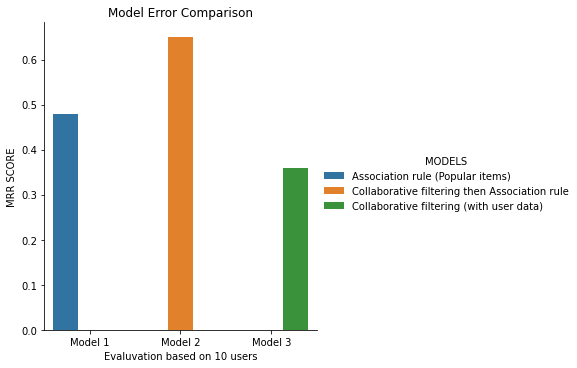

In [312]:
# 3 model MRR vale comparision
df = pd.DataFrame([['Model 1', mrr_1, "Association rule (Popular items)"],\
                   ['Model 2', mrr_2, "Collaborative filtering then Association rule"],\
                   ['Model 3', 0.36, "Collaborative filtering (with user data)"]]\
                  , columns=["Evaluvation based on 10 users", 'MRR SCORE', "MODELS"])

sns.factorplot(x='Evaluvation based on 10 users', y='MRR SCORE', hue='MODELS', data=df, kind='bar')\
                .set(title="Model Error Comparison")

### References

[1] Lee, C.H., Kim, Y.H. and Rhee, P.K., 2001. Web personalization expert with combining collaborative filtering and association rule mining technique. Expert Systems with Applications, 21(3), pp.131-137.

[2] Parvatikar, S. and Joshi, B., 2015, December. Online book recommendation system by using collaborative filtering and association mining. In 2015 IEEE International Conference on Computational Intelligence and Computing Research (ICCIC) (pp. 1-4). IEEE.

[3] Sun, X., Kong, F., Chen, H. (2005). Using Quantitative Association Rules in Collaborative Filtering. In: Fan, W., Wu, Z., Yang, J. (eds) Advances in Web-Age Information Management. WAIM 2005. Lecture Notes in Computer Science, vol 3739. Springer, Berlin, Heidelberg.

[4] https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

[5] https://medium.com/nerd-for-tech/evaluating-recommender-systems-590a7b87afa5

[6] https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832